# Imbalance ratio functions for binary and multi-class datasets:
    - Methods to quantify class imbalanceness in datasets
    - Performance Analysis
    - How to combat imbalance datasets

Testing with synthetic binary and multi-class datasets.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.pipeline import Pipeline

## Quantifying Class Imbalance in Datasets
#### Method 1: Imbalance Ratio based on class proportions (binary)
To quantify the imbalanceness of a binary dataset, a simple approach is to compute the imbalance ratio (IR), which is the ratio of the number of instances in the majority class to the number in the minority class.\
\
IR = count(Majority)/count(Minority) ~ Majority : Minority
- Identify majority and minority classes
- Compute the imbalance ratio

In [2]:
def calculate_imbalance_ratio(df, label_column):
    # Count the instances of each class
    class_counts = df[label_column].value_counts()
    
    # Identify the majority and minority classes
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    
    # Calculate the imbalance ratio
    imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]
    
    print(f"Class counts:\n{class_counts}")
    print(f"Majority class: {majority_class}, Minority class: {minority_class}")
    print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}")
    
    return imbalance_ratio

#### Method 2: Imbalance Ratio based on class proportions (multi-class)
For multi-class datasets, the imbalance ratio calculation extends by considering the ratio of the largest class to each of the other classes. One way to summarize imbalance in a multi-class setting is to calculate the average imbalance ratio across all classes.\
\
IR = count(Majority)/count(Class) ~ Majority : Class
- Identify majority class
- Calculate imbalance ratio for each class relative to the majority class
- Calculate average imbalance ratio

In [3]:
def calculate_multi_class_imbalance_ratio(df, label_column):
    # Count instances for each class
    class_counts = df[label_column].value_counts()
    total_classes = len(class_counts)
    
    # Find the largest (majority) class count
    majority_class_count = class_counts.max()
    
    # Calculate imbalance ratio for each class against the majority class
    imbalance_ratios = majority_class_count / class_counts
    average_imbalance_ratio = imbalance_ratios.mean()
    
    print("Class counts:")
    print(class_counts)
    print("\nImbalance Ratios:")
    print(imbalance_ratios.round(2))
    print(f"\nAverage Imbalance Ratio: {average_imbalance_ratio:.2f}")
    
    return average_imbalance_ratio, imbalance_ratios

#### Method 3: Imbalance Ratio with Shannon Entropy and Cohen's Kappa statistic (multi-class)

For multi-class datasets, the imbalance ratio calculation extends by considering the ratio of the largest class to each of the other classes. One way to summarize imbalance in a multi-class setting is to calculate the average imbalance ratio across all classes.

1. <ins>Average Imbalance Ratio (IR) Across All Classes</ins>
- Provides a single value representing the degree of imbalance across classes.

2. <ins>Shannon Entropy for Class Distribution</ins>
- Shannon entropy measures the diversity of class distribution i.e. a balanced dataset has maximum entropy and an imbalanced one has lower entropy. Lower entropy values indicate greater imbalance.
- High Entropy (close to 1 in normalized form): Indicates a balanced dataset where all classes are nearly equally represented. The more balanced the distribution, the higher the entropy.
- Low Entropy (closer to 0): Indicates imbalance, where one or more classes dominate, and there is less diversity in the class distribution

3. <ins>Cohen's Kappa Statistic</ins>
- Cohen's Kappa assesses the quality of a classifier by comparing the actual classifications with expected classifications under random guessing. For imbalanced datasets, Kappa provides insight into how well a model performs relative to the expected accuracy if predictions were made by simply guessing according to class frequencies.
- Kappa close to 1: Indicates strong agreement beyond chance; in classification, it means the model’s predictions are far better than random guessing.
- Kappa near 0: Suggests performance is near what would be expected by random chance. This is often seen in highly imbalanced datasets where a naive majority-class prediction strategy doesn’t provide meaningful results.
- Negative Kappa: Implies performance is worse than random guessing, suggesting systematic misclassification.
- Require majority class's prediction values to assess.*


In [4]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.metrics import cohen_kappa_score

# y: array of class labels
# y_majority_pred: majority class prediction values (optional)

def measure_class_imbalance(y, y_majority_pred=None):
    class_counts = np.bincount(y)
    n_samples = len(y)
    n_classes = len(class_counts)
    
    # Imbalance Ratio (IR) across all classes
    majority_class_count = class_counts.max()
    imbalance_ratios = majority_class_count / class_counts
    avg_imbalance_ratio = np.mean(imbalance_ratios)
    print(f"Average Imbalance Ratio (IR): {avg_imbalance_ratio:.2f}")
    
    # Shannon Entropy
    class_probabilities = class_counts / n_samples
    shannon_entropy = -np.sum(class_probabilities * np.log2(class_probabilities + 1e-9))  # Avoid log(0)
    normalized_entropy = shannon_entropy / np.log2(n_classes)
    print(f"Normalized Shannon Entropy: {normalized_entropy:.2f}")
    
    # 3. Cohen's Kappa
    if y_majority_pred is not None:
        kappa = cohen_kappa_score(y, y_majority_pred)
        print(f"Cohen's Kappa (majority class baseline): {kappa:.2f}")
    else:
        print("y_majority_pred is not provided; skipping Cohen's Kappa calculation.")
    
    return avg_imbalance_ratio, normalized_entropy, kappa if y_majority_pred is not None else None

### Trial 1: Testing against balanced datasets

Generating synthetic binary dataset.

In [5]:
# Binary dataset
X_bin, y_bin = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)

model_bin = RandomForestClassifier(random_state=42)
model_bin.fit(X_train_bin, y_train_bin)
y_pred_bin = model_bin.predict(X_test_bin)

In [6]:
classes, counts = np.unique(y_bin, return_counts=True)
df_bi = pd.DataFrame({'Class': classes, 'Count': counts})
display(df_bi)

,Class,Count
0,0,501
1,1,499


Generating synthetic multi-class dataset.

In [7]:
# Multi-class dataset
X_multi, y_multi = make_classification(n_samples=1000, n_features=10, n_classes=3, n_informative=8, random_state=42)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

model_multi = RandomForestClassifier(random_state=42)
model_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = model_bin.predict(X_test_multi)

In [8]:
classes, counts = np.unique(y_multi, return_counts=True)
df_multi = pd.DataFrame({'Class': classes, 'Count': counts})
display(df_multi)

,Class,Count
0,0,334
1,1,333
2,2,333


#### Performance Analysis
- Let us explore the synthetic data's confusion matrix. This hows the distribution of classes in both binary and multi-class datasets.

Confusion matrix of binary dataset:

True Positive:	 96
False Positive:	 9
True Negative:	 80
False Negative:	 15


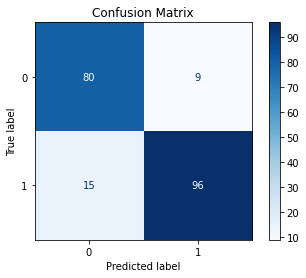

In [9]:
# Generate the confusion matrix
cm_bi = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bi, display_labels=model_bin.classes_)
print("True Positive:\t", cm_bi[1][1])
print("False Positive:\t", cm_bi[0][1])
print("True Negative:\t", cm_bi[0][0])
print("False Negative:\t", cm_bi[1][0])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Confusion matrix of multi-class dataset:

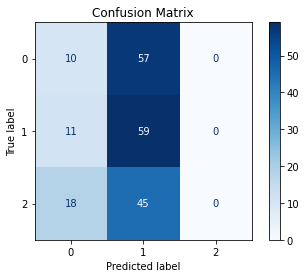

In [10]:
# Generate the confusion matrix
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi, display_labels=model_multi.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [11]:
df_bi = pd.DataFrame({'label': y_bin})
print('Method 1: Imbalance Ratio\n')
imbalance_ratio = calculate_imbalance_ratio(df_bi, 'label')
print('-'*30)
print('Method 3: Class Imbalance Metrics\n')
y_majority_pred = np.full_like(y_bin, fill_value=np.argmax(np.bincount(y_bin)))
avg_imbalance_ratio, normalized_entropy, kappa = measure_class_imbalance(y_bin, y_majority_pred)

Method 1: Imbalance Ratio

Class counts:
0    501
1    499
Name: label, dtype: int64
Majority class: 0, Minority class: 1
Imbalance Ratio (IR): 1.00
------------------------------
Method 3: Class Imbalance Metrics

Average Imbalance Ratio (IR): 1.00
Normalized Shannon Entropy: 1.00
Cohen's Kappa (majority class baseline): 0.00


<ins>Results</ins>

1. Imbalance Ratio (IR): 1.00, indicating equal representation of both classes.
2. Normalized Shannon Entropy: 1.00, confirming maximum class diversity.
3. Cohen’s Kappa: 0.00, meaning a majority-class-only prediction offers no advantage over random guessing due to the balanced distribution.

In summary, there’s no class imbalance, so additional balancing techniques are unnecessary

In [12]:
df_multi = pd.DataFrame({'label': y_multi})
print('Method 2: Imbalance Ratio\n')
calculate_multi_class_imbalance_ratio(df_multi, 'label')
print('-'*30)
print('Method 3: Class Imbalance Metrics\n')
majority_class = pd.Series(y_multi).mode()[0]
y_majority_pred = np.full_like(y_multi, fill_value=majority_class)
measure_class_imbalance(y_multi, y_majority_pred)

Method 2: Imbalance Ratio

Class counts:
0    334
2    333
1    333
Name: label, dtype: int64

Imbalance Ratios:
0    1.0
2    1.0
1    1.0
Name: label, dtype: float64

Average Imbalance Ratio: 1.00
------------------------------
Method 3: Class Imbalance Metrics

Average Imbalance Ratio (IR): 1.00
Normalized Shannon Entropy: 1.00
Cohen's Kappa (majority class baseline): 0.00


(1.002002002002002, 0.9999990873330142, 0.0)

<ins>Results</ins>

1. Imbalance Ratio (IR): The class counts are nearly equal, with 334 instances of class 0 and 333 for classes 1 and 2. The imbalance ratio for each class is 1.0, indicating no class imbalance in the dataset.
2. Average Imbalance Ratio: 1.00, confirming no imbalance.
2. Normalized Shannon Entropy: 1.00, confirming maximum class diversity due to the balanced distribution.
3. Cohen’s Kappa: 0.00, suggesting that predicting the majority class does not outperform random guessing, as the classes are equally represented.

The dataset is balanced with equal class distributions, as confirmed by the imbalance ratio, entropy, and Kappa score. No class imbalance is present, making the dataset well-suited for standard machine learning models.

### Trial 2: Testing against imbalanced datasets
Generating synthetic binary dataset. \
Setting weights = [0.25, 0.75]: To create an imbalanced dataset where 25% of the samples belong to class 0, and 75% belong to class 1.

In [13]:
# Imbalanced binary dataset
Xi_bin, yi_bin = make_classification(
    n_samples=1000,
    n_features=10,
    n_classes=2,
    weights=[0.25, 0.75],
    random_state=42)
Xi_train_bin, Xi_test_bin, yi_train_bin, yi_test_bin = train_test_split(Xi_bin, yi_bin, test_size=0.2, random_state=42)

model_bin = RandomForestClassifier(random_state=42)
model_bin.fit(Xi_train_bin, yi_train_bin)
yi_pred_bin = model_bin.predict(Xi_test_bin)

In [14]:
classes, counts = np.unique(yi_bin, return_counts=True)
dfi_bi = pd.DataFrame({'Class': classes, 'Count': counts})
display(dfi_bi)

,Class,Count
0,0,254
1,1,746


Generating synthetic multi-class dataset. \
Setting n_classes = 3 and weights = [0.1, 0.2, 0.7]:
- Class 0 will have 10% of the samples,
- Class 1 will have 20% of the samples,
- Class 2 will have 70% of the samples (the majority class).

In [15]:
Xi_multi, yi_multi = make_classification(
    n_samples=1000,
    n_features=10,
    n_classes=3,
    n_informative=5,
    weights=[0.1, 0.2, 0.7],
    random_state=42)
Xi_train_multi, Xi_test_multi, yi_train_multi, yi_test_multi = train_test_split(Xi_multi, yi_multi, test_size=0.2, random_state=42)

model_multi = RandomForestClassifier(random_state=42)
model_multi.fit(Xi_train_multi, yi_train_multi)
yi_pred_multi = model_multi.predict(Xi_test_multi)

In [16]:
classes, counts = np.unique(yi_multi, return_counts=True)
dfi_multi = pd.DataFrame({'Class': classes, 'Count': counts})
display(dfi_multi)

,Class,Count
0,0,100
1,1,201
2,2,699


#### Performance Analysis
- Let us explore the synthetic data's confusion matrix. This hows the distribution of classes in both binary and multi-class datasets.

Confusion matrix of binary dataset:

True Positive:	 140
False Positive:	 7
True Negative:	 39
False Negative:	 14


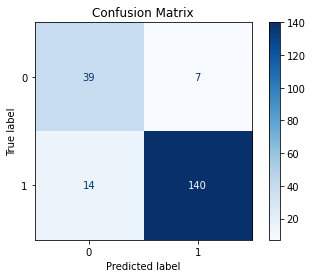

In [17]:
# Generate the confusion matrix
cm_bi = confusion_matrix(yi_test_bin, yi_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bi, display_labels=model_bin.classes_)
print("True Positive:\t", cm_bi[1][1])
print("False Positive:\t", cm_bi[0][1])
print("True Negative:\t", cm_bi[0][0])
print("False Negative:\t", cm_bi[1][0])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Confusion matrix of multi-class dataset:

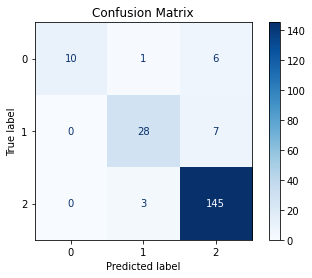

In [18]:
# Generate the confusion matrix
cm_multi = confusion_matrix(yi_test_multi, yi_pred_multi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi, display_labels=model_multi.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [19]:
dfi_bi = pd.DataFrame({'label': yi_bin})
print('Method 1: Imbalance Ratio\n')
imbalance_ratio = calculate_imbalance_ratio(dfi_bi, 'label')
print('-'*30)
print('Method 3: Class Imbalance Metrics\n')
yi_majority_pred = np.full_like(yi_bin, fill_value=np.argmax(np.bincount(yi_bin)))
avg_imbalance_ratio, normalized_entropy, kappa = measure_class_imbalance(yi_bin, yi_majority_pred)

Method 1: Imbalance Ratio

Class counts:
1    746
0    254
Name: label, dtype: int64
Majority class: 1, Minority class: 0
Imbalance Ratio (IR): 2.94
------------------------------
Method 3: Class Imbalance Metrics

Average Imbalance Ratio (IR): 1.97
Normalized Shannon Entropy: 0.82
Cohen's Kappa (majority class baseline): 0.00


<ins>Results</ins>

1. Imbalance Ratio (IR): 2.94, meaning class 1 is almost 3 times more frequent than class 0, indicating a moderate imbalance.
2. Average Imbalance Ratio: 1.97, confirming the imbalance where the minority class is roughly twice as underrepresented.
3. Normalized Shannon Entropy: 0.82, suggesting moderate unpredictability in the class distribution.
3. Cohen’s Kappa: 0.00, indicating no better agreement than random guessing when predicting the majority class.

The dataset is imbalanced with class 1 being the majority. The results highlight the need for models that can handle such imbalance, as predicting the majority class alone offers no better performance than random guessing.

In [20]:
dfi_multi = pd.DataFrame({'label': yi_multi})
print('Method 2: Imbalance Ratio\n')
calculate_multi_class_imbalance_ratio(dfi_multi, 'label')
print('-'*30)
print('Method 3: Class Imbalance Metrics\n')
majority_class = pd.Series(yi_multi).mode()[0]
yi_majority_pred = np.full_like(yi_multi, fill_value=majority_class)
measure_class_imbalance(yi_multi, yi_majority_pred)

Method 2: Imbalance Ratio

Class counts:
2    699
1    201
0    100
Name: label, dtype: int64

Imbalance Ratios:
2    1.00
1    3.48
0    6.99
Name: label, dtype: float64

Average Imbalance Ratio: 3.82
------------------------------
Method 3: Class Imbalance Metrics

Average Imbalance Ratio (IR): 3.82
Normalized Shannon Entropy: 0.73
Cohen's Kappa (majority class baseline): 0.00


(3.8225373134328358, 0.7309840881314108, 0.0)

<ins>Results</ins>

1. Imbalance Ratio (IR): Class 2 is the majority (1.00), class 1 is 3.48 times less frequent, and class 0 is 6.99 times less frequent.
2. Average Imbalance Ratio: 3.82, confirming the strong imbalance.
2. Normalized Shannon Entropy: 0.73, showing moderate class diversity.
3. Cohen’s Kappa: 0.00, indicating no improvement over random guessing when predicting the majority class.

The dataset is highly imbalanced, with class 2 dominating. The Kappa score of 0.00 suggests that predicting the majority class alone doesn’t provide useful predictions.

## Methods to Counter Class Imbalance in Datasets
Class imbalance significantly impacts model performance, as models tend to prioritize the majority class and may overlook the minority class. We can balance the class distribution with resampling.

1. <ins>Interpolating from minority class</ins>
- Synthetic Minority Over-sampling Technique (SMOTE) generates synthetic samples for the minority class by interpolating between existing samples. SMOTE is effective but may introduce noise and overfitting of the minority class.
2. <ins>Undersampling the Majority Class</ins>
- Randomly removes samples from the majority class. This can prevent overfitting but may also discard useful information from the majority class.
3. <ins>Tomek Links</ins>
- Removes overlapping examples from the majority class that are near the minority class boundary, helping create a cleaner decision boundary.
4. <ins>NearMiss</ins>
- Selectively keeps majority class samples that are closest to the minority class to preserve useful information while reducing the class imbalance.

#### Approach to counter class imbalance
Method 1: SMOTE + Tomek Links\
Method 2: SMOTE + Edited Nearest Neighbors (ENN)\
SMOTE is combined with methods that clean up noisy samples, leading to a more balanced yet cleaner dataset.

In [21]:
# SMOTE + Tomek Links pipeline
smote_tomek_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('tomek', TomekLinks())])

# Apply SMOTE + Tomek Links to the training set
X_resampled1, y_resampled1 = smote_tomek_pipeline.fit_resample(Xi_train_bin, yi_train_bin)
model1 = RandomForestClassifier(random_state=42)
model1.fit(X_resampled1, y_resampled1)
y1 = model1.predict(Xi_test_bin)

In [22]:
classes, counts = np.unique(yi_train_bin, return_counts=True)
print("Class count of training data before resampling:")
dfi_bi = pd.DataFrame({'Class': classes, 'Count': counts})
display(dfi_bi)

Class count of training data before resampling:


,Class,Count
0,0,208
1,1,592


In [23]:
classes, counts = np.unique(y_resampled1, return_counts=True)
df_bi = pd.DataFrame({'Class': classes, 'Count': counts})
print("Class count of training data after resampling via Tomek Links:")
display(df_bi)

Class count of training data after resampling via Tomek Links:


,Class,Count
0,0,592
1,1,588


In [24]:
df1 = pd.DataFrame({'label': y_resampled1})
print("Class imbalance results for resampled data via Tomek Links: \n")
print('Method 1: Imbalance Ratio\n')
imbalance_ratio = calculate_imbalance_ratio(df1, 'label')
print('-'*30)
print('Method 3: Class Imbalance Metrics\n')
y1_majority_pred = np.full_like(y_resampled1, fill_value=np.argmax(np.bincount(y_resampled1)))
avg_imbalance_ratio, normalized_entropy, kappa = measure_class_imbalance(y_resampled1, y1_majority_pred)

Class imbalance results for resampled data via Tomek Links: 

Method 1: Imbalance Ratio

Class counts:
0    592
1    588
Name: label, dtype: int64
Majority class: 0, Minority class: 1
Imbalance Ratio (IR): 1.01
------------------------------
Method 3: Class Imbalance Metrics

Average Imbalance Ratio (IR): 1.00
Normalized Shannon Entropy: 1.00
Cohen's Kappa (majority class baseline): 0.00


<ins>Results</ins>

1. Imbalance Ratio (IR): The imbalance ratio of 1.01 indicates almost perfect balance between the majority and minority classes, meaning the classes are nearly equal in size.
2. Average Imbalance Ratio: 1.00 confirms that the dataset is effectively balanced after Tomek Links resampling.
2. Normalized Shannon Entropy: 1.00 suggests maximum uncertainty in the class distribution, meaning the dataset is highly balanced with equal class representation.
3. Cohen’s Kappa: 0.00 indicates that predicting the majority class alone yields no better performance than random guessing, which might imply that the model is struggling to find patterns beyond the class distribution.

The dataset is nearly balanced (IR ~ 1.01), and the class distribution is highly uniform. However, the Cohen's Kappa of 0.00 suggests that the model is not making meaningful predictions, possibly due to inadequate learning or a lack of discriminative features. Class imbalance is corrected with resampling via Tomek Links.

In [25]:
# SMOTE + ENN pipeline
smote_enn_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('enn', EditedNearestNeighbours())
])

# Apply SMOTE + ENN to the training set
X_resampled2, y_resampled2 = smote_enn_pipeline.fit_resample(Xi_train_bin, yi_train_bin)
model2 = RandomForestClassifier(random_state=42)
model2.fit(X_resampled2, y_resampled2)
y2 = model2.predict(Xi_test_bin)

In [26]:
classes, counts = np.unique(y_resampled2, return_counts=True)
dfi_multi = pd.DataFrame({'Class': classes, 'Count': counts})
print("Class count after resampling via ENN:")
display(dfi_multi)

Class count after resampling via ENN:


,Class,Count
0,0,592
1,1,438


In [27]:
df2 = pd.DataFrame({'label': y_resampled2})
print("Class imbalance results for resampled data via ENN: \n")
print('Method 1: Imbalance Ratio\n')
imbalance_ratio = calculate_imbalance_ratio(df2, 'label')
print('-'*30)
print('Method 3: Class Imbalance Metrics\n')
y2_majority_pred = np.full_like(y_resampled2, fill_value=np.argmax(np.bincount(y_resampled2)))
avg_imbalance_ratio, normalized_entropy, kappa = measure_class_imbalance(y_resampled2, y2_majority_pred)

Class imbalance results for resampled data via ENN: 

Method 1: Imbalance Ratio

Class counts:
0    592
1    438
Name: label, dtype: int64
Majority class: 0, Minority class: 1
Imbalance Ratio (IR): 1.35
------------------------------
Method 3: Class Imbalance Metrics

Average Imbalance Ratio (IR): 1.18
Normalized Shannon Entropy: 0.98
Cohen's Kappa (majority class baseline): 0.00


<ins>Results</ins>

1. Imbalance Ratio (IR): The imbalance ratio of 1.35 suggests a moderate imbalance, with the majority class being 1.35 times more frequent than the minority class.
2. Average Imbalance Ratio: 1.18 confirms the moderate imbalance in the dataset.
2. Normalized Shannon Entropy: 0.98 indicates that the class distribution is somewhat unpredictable but not highly skewed. The closer to 1, the more balanced the dataset is, so this suggests relatively high entropy.
3. Cohen’s Kappa: 0.00 shows that predicting the majority class alone does not perform better than random guessing.

The dataset is moderately imbalanced (IR ~ 1.35). Class imbalance is reduced after resampling with ENN, though less effective than via Tomek Links.

In [28]:
# Apply SMOTE + Tomek Links to the training set
X_resampled3, y_resampled3 = smote_tomek_pipeline.fit_resample(Xi_train_multi, yi_train_multi)
model3 = RandomForestClassifier(random_state=42)
model3.fit(X_resampled3, y_resampled3)
y3 = model3.predict(Xi_test_multi)

In [29]:
classes, counts = np.unique(yi_train_multi, return_counts=True)
print("Class count of training data before resampling:")
dfi_multi = pd.DataFrame({'Class': classes, 'Count': counts})
display(dfi_multi)

Class count of training data before resampling:


,Class,Count
0,0,83
1,1,166
2,2,551


In [30]:
classes, counts = np.unique(y_resampled3, return_counts=True)
df_multi = pd.DataFrame({'Class': classes, 'Count': counts})
print("Class count of training data after resampling via Tomek Links:")
display(df_multi)

Class count of training data after resampling via Tomek Links:


,Class,Count
0,0,551
1,1,548
2,2,545


In [31]:
df3 = pd.DataFrame({'label': y_resampled3})
print("Class imbalance results for resampled data via Tomek Links: \n")
print('Method 2: Imbalance Ratio\n')
imbalance_ratio = calculate_multi_class_imbalance_ratio(df3, 'label')
print('-'*30)
print('Method 3: Class Imbalance Metrics\n')
y3_majority_pred = np.full_like(y_resampled3, fill_value=np.argmax(np.bincount(y_resampled3)))
avg_imbalance_ratio, normalized_entropy, kappa = measure_class_imbalance(y_resampled3, y3_majority_pred)

Class imbalance results for resampled data via Tomek Links: 

Method 2: Imbalance Ratio

Class counts:
0    551
1    548
2    545
Name: label, dtype: int64

Imbalance Ratios:
0    1.00
1    1.01
2    1.01
Name: label, dtype: float64

Average Imbalance Ratio: 1.01
------------------------------
Method 3: Class Imbalance Metrics

Average Imbalance Ratio (IR): 1.01
Normalized Shannon Entropy: 1.00
Cohen's Kappa (majority class baseline): 0.00


<ins>Results</ins>

1. Imbalance Ratio (IR): The imbalance ratios for each class are very close to 1.00 (1.00 for class 0, 1.01 for class 1 and 2), indicating that all three classes are almost perfectly balanced.
2. Average Imbalance Ratio: The average imbalance ratio of 1.01 confirms that the classes are almost perfectly balanced, with minimal difference between them.
2. Normalized Shannon Entropy: A value of 1.00 suggests maximum entropy, which means the dataset is well-balanced and there is no dominant class.
3. Cohen’s Kappa: 0.00 shows that predicting the majority class alone does not perform better than random guessing.

The dataset is nearly perfectly balanced across all three classes (IR ~ 1.01). However, the Cohen's Kappa of 0.00 suggests that the model is not providing useful predictions, possibly because the model is overfitting to the balanced distribution or not capturing the underlying patterns in the data.

In [32]:
# Apply SMOTE + ENN to the training set
X_resampled4, y_resampled4 = smote_enn_pipeline.fit_resample(Xi_train_multi, yi_train_multi)
model4 = RandomForestClassifier(random_state=42)
model4.fit(X_resampled4, y_resampled4)
y4 = model4.predict(Xi_test_multi)

In [33]:
classes, counts = np.unique(y_resampled4, return_counts=True)
df_multi = pd.DataFrame({'Class': classes, 'Count': counts})
print("Class count of training data after resampling via ENN: ")
display(df_multi)

Class count of training data after resampling via ENN: 


,Class,Count
0,0,551
1,1,515
2,2,378


In [34]:
df4 = pd.DataFrame({'label': y_resampled4})
print("Class imbalance results for resampled data via ENN: \n")
print('Method 2: Imbalance Ratio\n')
imbalance_ratio = calculate_multi_class_imbalance_ratio(df4, 'label')
print('-'*30)
print('Method 3: Class Imbalance Metrics\n')
y4_majority_pred = np.full_like(y_resampled4, fill_value=np.argmax(np.bincount(y_resampled4)))
avg_imbalance_ratio, normalized_entropy, kappa = measure_class_imbalance(y_resampled4, y4_majority_pred)

Class imbalance results for resampled data via ENN: 

Method 2: Imbalance Ratio

Class counts:
0    551
1    515
2    378
Name: label, dtype: int64

Imbalance Ratios:
0    1.00
1    1.07
2    1.46
Name: label, dtype: float64

Average Imbalance Ratio: 1.18
------------------------------
Method 3: Class Imbalance Metrics

Average Imbalance Ratio (IR): 1.18
Normalized Shannon Entropy: 0.99
Cohen's Kappa (majority class baseline): 0.00


<ins>Results</ins>

1. Imbalance Ratio (IR): Class 0 has an imbalance ratio of 1.00 (reference class). Class 1 has a ratio of 1.07, indicating a mild imbalance with respect to class 0. Class 2 has a ratio of 1.46, showing the largest imbalance compared to class 0, but still moderate overall.
2. Average Imbalance Ratio: The average imbalance ratio of 1.18 suggests a moderate imbalance across all classes.
2. Normalized Shannon Entropy: The value of 0.99 is close to 1, indicating a highly balanced class distribution with minimal dominance from any single class.
3. Cohen’s Kappa: 0.00 shows that predicting the majority class alone does not perform better than random guessing. The model is not capturing meaningful patterns in the data or is relying on simple heuristics like class frequencies.

After applying ENN, the dataset is more balanced, with a moderate imbalance (IR ~ 1.18). The model, however, seems to be underperforming, as indicated by the Cohen's Kappa score of 0.00, suggesting that it isn't learning useful patterns beyond the class distribution. The slight imbalance in class 2 still might be influencing model performance.

#### Conclusion on methods to counter class imbalance
Resampling via SMOTE + Tomek Links has proven to be more effective in correcting class imbalance for both binary and multi-class datasets, as compared to ENN. However, low Cohen's Kappa score suggests that overfitting or underfitting may exist in the resampled prediction data.